In [3]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv

In [4]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

### Normal

In [5]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3, prior_var = 1 ):
        super(MeanFieldLayer, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.normal.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.normal.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.normal.Normal(self.w_mu_q, torch.exp(0.5 * self.w_log_var_q))

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.normal.Normal(self.b_mu_q, torch.exp(0.5 * self.b_log_var_q))

    
    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum()
        bias_kl   = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return torch.sum(weight_kl + bias_kl)
        

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."

        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        
        return x @ weights + biases

class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1.0
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim     = input_dim
        self.hidden_dims   = hidden_dims
        self.output_dim    = output_dim
        self.activation    = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
                self.network.append(torch.nn.Softmax(dim=2))
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=10):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for i, layer in enumerate(self.network):
            x = layer(x)
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, (0.5 * self.b_log_var_p).exp())
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x)#, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred)
        kl     = self.kl()
        return kl - exp_ll, exp_ll, kl

### Student T

In [6]:
class MeanFieldLayer_T(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, df, init_var=1e-3, prior_var = 1 ):
        super(MeanFieldLayer_T, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.df         = df

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.StudentT(self.df, self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.StudentT(self.df, self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.StudentT(self.df, self.w_mu_q, torch.exp(0.5 * self.w_log_var_q))

    def q_b(self):
        """variational bias posterior"""#
        return torch.distributions.StudentT(self.df, self.b_mu_q, torch.exp(0.5 * self.b_log_var_q))

    
    def kl(self, num_samples = 10):
        weight_samples = self.q_w().rsample((num_samples,))  # rsample allows for gradient propagation
        bias_samples = self.q_b().rsample((num_samples,))

        log_q_w = self.q_w().log_prob(weight_samples)  
        log_p_w = self.p_w().log_prob(weight_samples)

        log_q_b = self.q_b().log_prob(bias_samples)
        log_p_b = self.p_b().log_prob(bias_samples)

        weight_kl = (log_q_w - log_p_w).mean()  # Average over samples
        bias_kl = (log_q_b - log_p_b).mean()
        return weight_kl + bias_kl
        

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).


        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        
        return x @ weights + biases # (num_samples, batch_size, output_dim).



class MeanFieldBNN_T(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        df = 10,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1.0
    ):
        super(MeanFieldBNN_T, self).__init__()
        self.input_dim     = input_dim
        self.hidden_dims   = hidden_dims
        self.output_dim    = output_dim
        self.activation    = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        self.df            = df

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer_T(self.input_dim, self.hidden_dims[i], self.df, prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer_T(self.hidden_dims[i - 1], self.output_dim, self.df, prior_var = prior_var)
                )
                self.network.append(torch.nn.Softmax(dim=2))
            else:
                self.network.append(
                    MeanFieldLayer_T(self.hidden_dims[i - 1], self.hidden_dims[i], self.df, prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=10):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for i, layer in enumerate(self.network):
            x = layer(x)
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim
        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        l = torch.distributions.normal.Normal(y_pred, (0.5 * self.b_log_var_p).exp())
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    def kl(self, num_samples = 10):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(num_samples = num_samples) for layer in self.network if isinstance(layer, MeanFieldLayer_T)])

    def loss(self, x, y, num_samples=10):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        #print('y, pred, numder', y[50:60], y_pred[0][50:60], num_samples)
        exp_ll = self.ll(y, y_pred).sum()
        kl = self.kl(num_samples = num_samples).sum()

        return kl - exp_ll, exp_ll, kl

### Uniform

In [7]:
class MeanFieldLayer_unf(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3, prior_var = 1 ):
        super(MeanFieldLayer_unf, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.normal.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.normal.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Uniform(self.w_mu_q - torch.exp(0.5 * self.w_log_var_q), self.w_mu_q + torch.exp(0.5 * self.w_log_var_q))

    def q_b(self):
        """variational bias posterior"""#
        return torch.distributions.Uniform(self.b_mu_q - torch.exp(0.5 * self.b_log_var_q), self.b_mu_q + torch.exp(0.5 * self.b_log_var_q))

    
    def kl(self, num_samples = 10):
        weight_samples = self.q_w().rsample((num_samples,))  # rsample allows for gradient propagation
        bias_samples = self.q_b().rsample((num_samples,))

        log_q_w = self.q_w().log_prob(weight_samples)  
        log_p_w = self.p_w().log_prob(weight_samples)

        log_q_b = self.q_b().log_prob(bias_samples)
        log_p_b = self.p_b().log_prob(bias_samples)

        weight_kl = (log_q_w - log_p_w).mean()  # Average over samples
        bias_kl = (log_q_b - log_p_b).mean()
        return weight_kl + bias_kl
        

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).


        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        
        return x @ weights + biases # (num_samples, batch_size, output_dim).



class MeanFieldBNN_unf(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1.0
    ):
        super(MeanFieldBNN_unf, self).__init__()
        self.input_dim     = input_dim
        self.hidden_dims   = hidden_dims
        self.output_dim    = output_dim
        self.activation    = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))#

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer_unf(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer_unf(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    MeanFieldLayer_unf(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=10):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for i, layer in enumerate(self.network):
            x = layer(x)
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim
        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        l = torch.distributions.normal.Normal(y_pred, (0.5 * self.b_log_var_p).exp())
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    def kl(self, num_samples = 10):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(num_samples = num_samples) for layer in self.network if isinstance(layer, MeanFieldLayer_unf)])

    def loss(self, x, y, num_samples=10):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        #print('y, pred, numder', y[50:60], y_pred[0][50:60], num_samples)
        exp_ll = self.ll(y, y_pred).sum()
        kl = self.kl(num_samples = num_samples).sum()

        return kl - exp_ll, exp_ll, kl

### Laplace distridution

In [8]:
class MeanFieldLayer_lap(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, prior_var = 1 ):
        super(MeanFieldLayer_lap, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Laplace(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Laplace(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Laplace(self.w_mu_q, torch.exp(0.5 * self.w_log_var_q))

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Laplace(self.b_mu_q, torch.exp(0.5 * self.b_log_var_q))

    
    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum()
        bias_kl   = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return torch.sum(weight_kl + bias_kl)
        

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."

        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        
        return x @ weights + biases

class MeanFieldBNN_lap(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1.0
    ):
        super(MeanFieldBNN_lap, self).__init__()
        self.input_dim     = input_dim
        self.hidden_dims   = hidden_dims
        self.output_dim    = output_dim
        self.activation    = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer_lap(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer_lap(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    MeanFieldLayer_lap(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=10):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for i, layer in enumerate(self.network):
            x = layer(x)
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, (0.5 * self.b_log_var_p).exp())
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer_lap)])

    def loss(self, x, y):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x)#, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred)
        kl     = self.kl()
        return kl - exp_ll, exp_ll, kl

### Training model

In [9]:

# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
def model_train(bnn_model, x_tr, x_te, y_tr, y_te, num_epoch, error_type = nn.MSELoss()):

    opt = torch.optim.Adam(
        bnn_model.parameters(),
        lr = 1e-2
    )

    tr_loss_evo = []
    tr_ll_evo = []
    tr_kl_evo = []
    te_loss_evo = []

    tr_loss_evo = []
    te_loss_evo = []
    aux_loss = error_type



    for epoch in tqdm(range(num_epoch)):  # epochs
        opt.zero_grad()

        l, ll, kl = bnn_model.loss(x_tr, y_tr)
        tr_loss_evo.append(l.item())
        tr_ll_evo.append(ll.item())
        tr_kl_evo.append(kl.item())
        tr_loss_evo.append(aux_loss(bnn_model(x_tr).mean(0), y_tr.unsqueeze(0)).item()) 

        te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
        te_loss_evo.append(aux_loss(bnn_model(x_te).mean(0), y_te.unsqueeze(0)).item()) 

        l.backward()
        opt.step()

    plt.rcParams["figure.figsize"] = (10, 4)

    plt.plot(tr_loss_evo, label='Train dataset loss')
    plt.plot(te_loss_evo, label='Test dataset loss')
    plt.ylabel('ELBO loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Loss Evolution')
    plt.show()

    plt.plot(tr_ll_evo, label='Train dataset log-like evo')
    plt.ylabel('expected log likelihood')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Expected Log Likelihood Evolution')
    plt.show()

    plt.plot(tr_kl_evo, label='Train dataset kl evo')
    plt.ylabel('kl')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('KL Evolution')
    plt.show()

    plt.plot(tr_loss_evo, label='Train dataset')
    plt.plot(te_loss_evo, label='Test dataset')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('MSE Evolution')
    plt.show()

    return bnn_model 


### Data US weather

In [10]:
city = []
with open('Data on US weather/city_info.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        city = city + [row]
n = len(city)
weather_in_us = []
ys            = []
for index in range(1, n - 1):
    ID      = city[index][2]

    if ID != city[index + 1][2]:
        Lat      = float(city[index][3])
        Lon      = float(city[index][4])
        Location = [Lat, Lon]

        with open('Data on US weather/' + ID + '.csv', newline='') as csvfile:
            csvreader = csv.reader(csvfile)
            for row in csvreader:
                if row[0] != '' and row[2] != 'NA' and row[3] != 'NA' and row[4] != 'NA':
                    elements = Location[:] + [float(row[1][:4]), float(row[1][5:7]), float(row[1][8:10])] # year, mouth, day
                    weather_in_us.append(elements)
                    
                    ys.append([float(row[2]), float(row[3]), float(row[4])])  #tempature maxium, tempature minium, precipitation 
                    
                    


KeyboardInterrupt: 

In [ ]:

lat_lon_year_mouth_day   = torch.tensor(weather_in_us)
temp_max_min_precipition = torch.tensor(ys)


In [ ]:
i = 6
print(lat_lon_year_mouth_day_max_min_temp[:,i].max())
print(lat_lon_year_mouth_day_max_min_temp[:,i].mean())
print(lat_lon_year_mouth_day_max_min_temp[:,i].min())

print(precipition.max())
print(precipition.mean())
print(precipition.min())

tensor(100.)
tensor(44.7281)
tensor(-59.)
tensor(22.7500)
tensor(0.0940)
tensor(0.)


In [ ]:
x_tr, x_test, y_tr, y_test = train_test_split(lat_lon_year_mouth_day, temp_max_min_precipition, test_size = 1-1/20000, random_state = 13)
x_te, ____, y_te, ____     = train_test_split(x_test, y_test, test_size = 1-1/20000, random_state = 13)

In [ ]:
#bnn_model_unf  = model_train(MeanFieldBNN_unf(5, [20, 20, 20], 3, noise_std = 0.15, activation = nn.NLLLoss()), x_tr, x_te, y_tr, y_te, 4000)
bnn_model_norm = model_train(MeanFieldBNN(5, [20, 20, 20], 3, noise_std = 0.15, activation = nn.ReLU()), x_tr, x_te, y_tr, y_te, 4000)
bnn_model_T    = model_train(MeanFieldBNN_T(5, [20, 20, 20], 3, noise_std = 0.15, activation = nn.ReLU()), x_tr, x_te, y_tr, y_te, 4000)
bnn_model_lap  = model_train(MeanFieldBNN_lap(5, [20, 20, 20], 3, noise_std = 0.15, activation = nn.ReLU()), x_tr, x_te, y_tr, y_te, 4000)




  0%|          | 0/4000 [00:00<?, ?it/s]


ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([493, 3]) vs torch.Size([10, 493]).

### Data white wine

In [12]:
wine = []
with open('wine/winequality-red.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        wine = wine + [row]
n = len(wine)
X = []
Y = []
for i in range(1, n):
    alist = []
    for element in wine[i][:-2]:
        alist.append(float(element))
    X.append(alist)
    Y.append(int(wine[i][-1]))

X = torch.tensor(X)    
Y = torch.tensor(Y, dtype=torch.long)      
                    

In [13]:
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size = 1/4, random_state = 13)
print(wine[0])

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


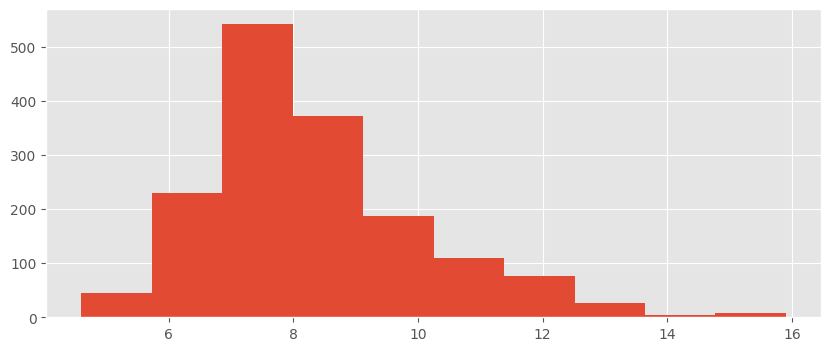

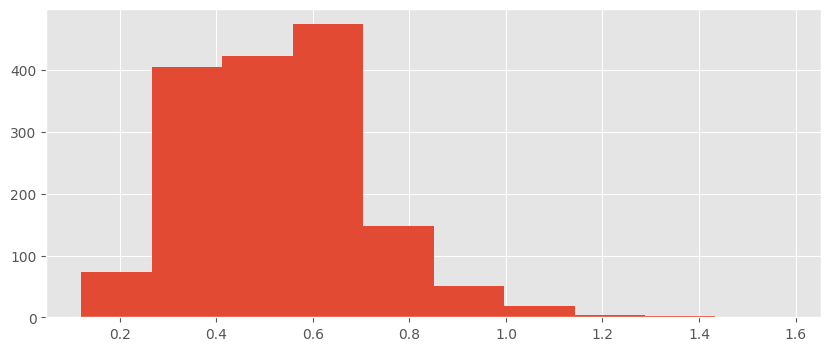

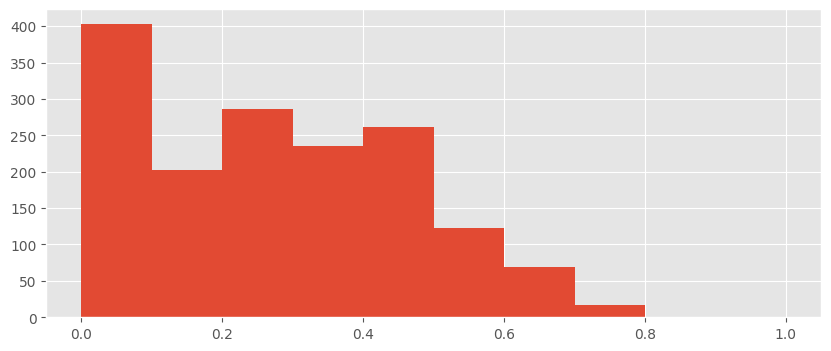

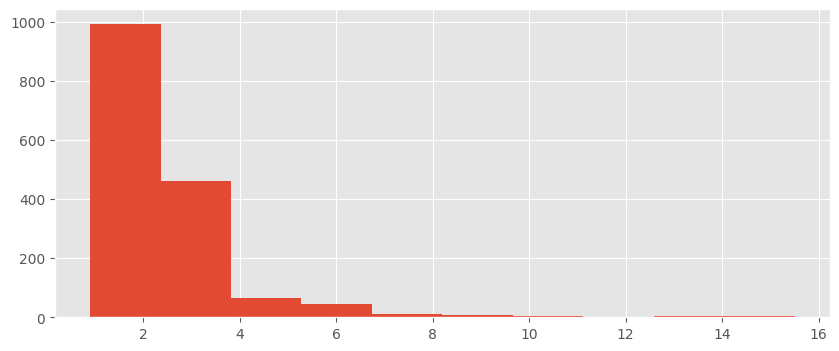

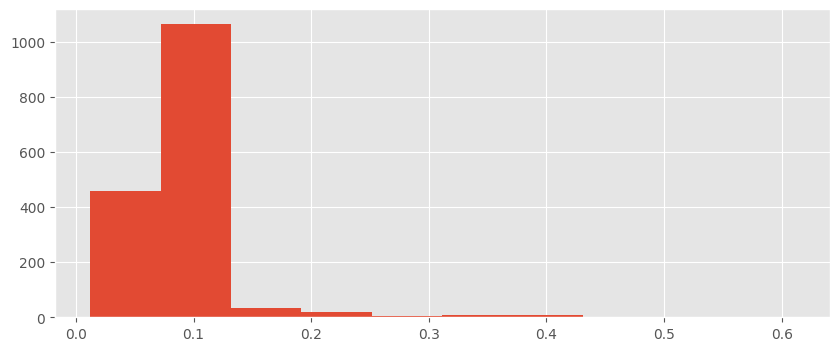

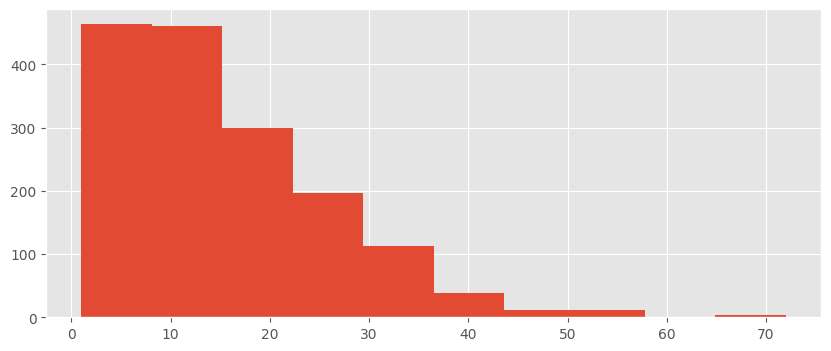

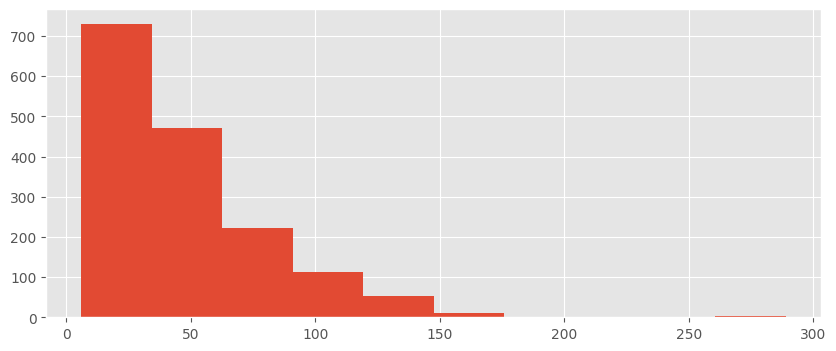

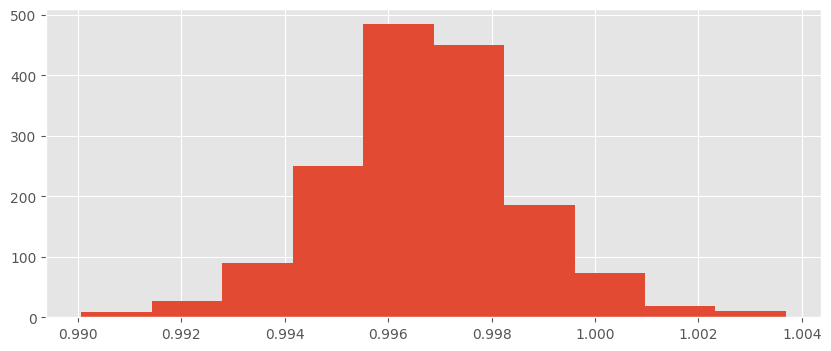

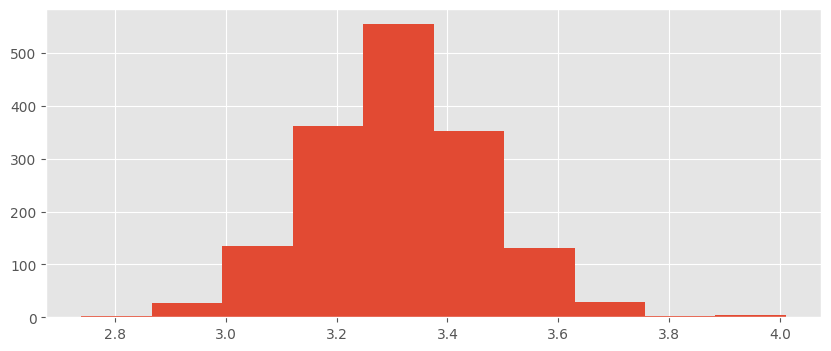

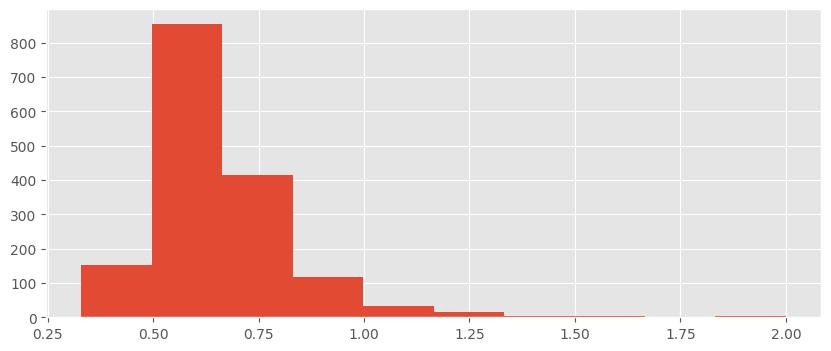

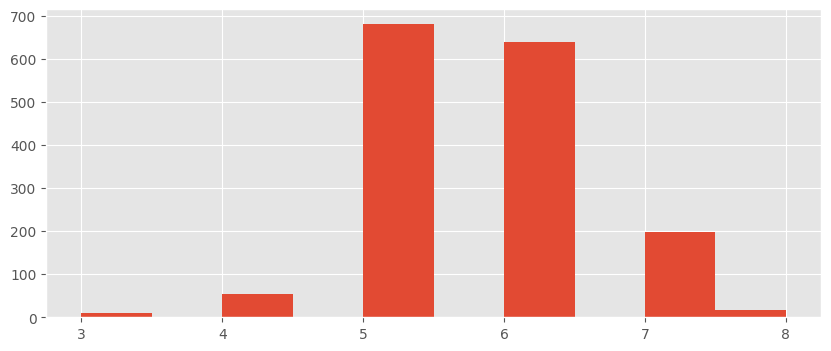

In [14]:
for i in range(10):
    plt.hist(X[:, i].numpy())
    plt.show()
plt.hist(Y.numpy())
plt.show()

In [15]:
bnn_model_unf  = model_train(MeanFieldBNN_unf(10, [20, 20, 20], 10, noise_std = 0.15, activation = nn.ReLU()), x_tr, x_te, y_tr, y_te, 2000)
bnn_model_norm = model_train(MeanFieldBNN(10, [20, 20, 20], 10, noise_std = 0.15, activation = nn.ReLU(), prior_var = 10), x_tr, x_te, y_tr, y_te, 2000)
bnn_model_T    = model_train(MeanFieldBNN_T(10, [20, 20, 20], 10, noise_std = 0.15, activation = nn.ReLU(), prior_var = 10), x_tr, x_te, y_tr, y_te, 2000)
bnn_model_lap  = model_train(MeanFieldBNN_lap(10, [20, 20, 20], 10, noise_std = 0.15, activation = nn.ReLU(), prior_var = 10), x_tr, x_te, y_tr, y_te, 2000)


  0%|          | 0/2000 [00:00<?, ?it/s]


AttributeError: 'MeanFieldBNN_unf' object has no attribute 'b_log_var_p'

In [ ]:
num_samps = 100

def S_of_Sq(preds, y_te):
    num_samps = preds.size()[0]
    size      = preds.size()[1]
    error     = 0
    for i1 in range(num_samps):
        for i2 in range(size):
            error += (preds[i1,i2] - y_te[i2])**2
    return error/(size+num_samps)


preds_norm   = bnn_model_norm(x_te, num_samples = num_samps).squeeze(-1).detach()
S_of_Sq_norm = S_of_Sq(preds_norm, y_te)

preds_T      = bnn_model_T(x_te, num_samples=num_samps).squeeze(-1).detach()
S_of_Sq_T    = S_of_Sq(preds_T, y_te)

preds_lap    = bnn_model_lap(x_te, num_samples=num_samps).squeeze(-1).detach()
S_of_Sq_lap  = S_of_Sq(preds_lap, y_te)
print(S_of_Sq_norm, S_of_Sq_T, S_of_Sq_lap)


tensor(5.2528e+09) tensor(1.1305e+08) tensor(2.3025e+11)


In [ ]:
n          = x_te.size()[0]
preds_norm = torch.mean(bnn_model_norm(x_te, num_samples=num_samps).squeeze(-1).detach(), dim=0)
print(preds_norm- y_te , preds_T - y_te, preds_lap - y_te)
ACC_norm   = torch.sum(abs(preds_norm - y_te)).numpy()/n
preds_T    = torch.mean(bnn_model_T(x_te, num_samples=num_samps).squeeze(-1).detach(), dim=0)
ACC_T      = torch.sum(abs(preds_T - y_te)).numpy()/n
preds_lap  = torch.mean(bnn_model_lap(x_te, num_samples=num_samps).squeeze(-1).detach(), dim=0)
ACC_lap    = torch.sum(abs(preds_lap - y_te)).numpy()/n

print(ACC_norm, ACC_T, ACC_lap)

tensor([-2.5533e+00, -1.9209e+00, -1.7634e+00, -1.7997e+00, -2.7133e+00,
        -1.5055e+00, -1.6615e+00, -2.2045e+00, -1.6610e+00, -2.2494e+00,
        -2.7996e+00, -3.0388e+00, -1.1263e+00, -2.9036e+00, -3.8406e+00,
        -4.7095e+00, -2.0846e+00, -3.6239e+00, -3.3019e+00, -6.6919e-01,
        -2.7146e+00, -1.7607e+00, -2.4070e+00, -1.7821e+00, -3.6669e+00,
        -1.6886e+00, -1.8231e+00, -1.6459e+00, -1.5724e+00, -1.7044e+00,
        -2.5450e+00, -1.8091e+00, -1.8473e+00, -1.3613e+00, -1.5642e+00,
        -2.8430e+00, -1.7455e+00, -2.0978e+00, -1.6563e+00, -2.4329e+00,
        -1.6640e+00, -1.6582e+00, -2.6089e+00, -3.2138e+00, -1.9102e+00,
        -1.5454e+00, -2.6414e+00, -4.0974e+00, -5.1569e+00, -2.5979e+00,
        -1.8474e+00, -2.6869e+00, -2.3890e+00, -2.4081e+00, -3.2186e+00,
        -2.6591e+00, -2.8506e+00, -3.5845e+00, -1.7018e+00, -1.5820e+00,
        -1.2950e+00, -1.7998e+00, -1.8298e+00, -2.5052e+00, -3.9113e+00,
        -3.8514e+00, -1.4038e+00, -1.7882e+00, -1.5

In [ ]:
i = 1
print(preds_norm)
print(preds_norm.mean(0))

tensor([-0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270, -0.9270,
        -0.9270, -0.9270, -0.9270, -0.92